In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
encoder = OneHotEncoder()
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor

In [3]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    return df

In [4]:
df = wrangle("/kaggle/input/bike-sharing-demand/train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df.season.value_counts()

season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64

<Figure size 1000x800 with 0 Axes>

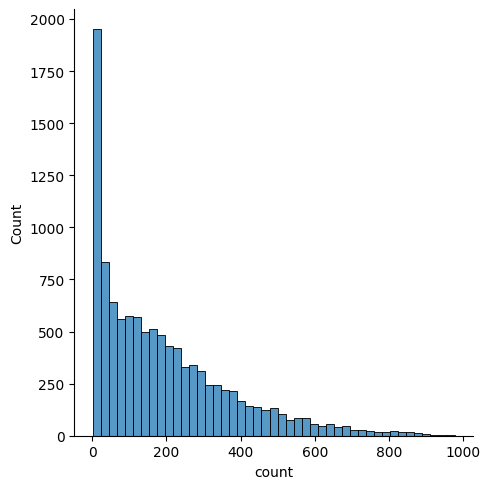

In [6]:
plt.figure(figsize=(10, 8))
sns.displot(df["count"])
plt.show()

In [7]:
df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [8]:
df['season'].replace({1 : "spring", 2 : "summer", 3 : "fall", 4 : "winter"}, inplace=True)

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['time'] = df['datetime'].dt.hour

In [10]:
huge_df = df[df['count'] >= 200]


In [11]:
counts_per_month = df['datetime'].dt.month_name().value_counts()
counts_per_month.index

Index(['May', 'June', 'July', 'August', 'December', 'October', 'November',
       'April', 'September', 'February', 'March', 'January'],
      dtype='object', name='datetime')

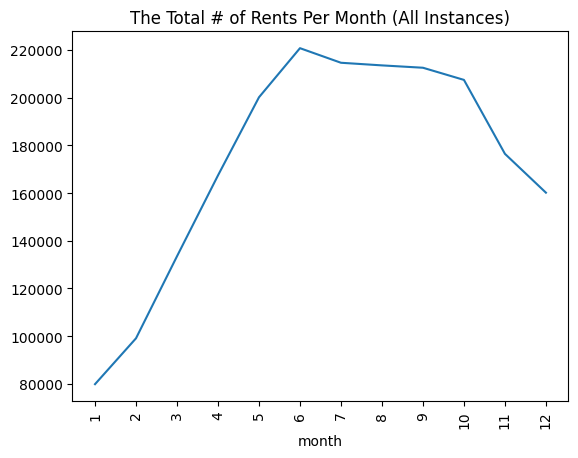

In [12]:
counts_per_month = df.groupby('month')['count'].sum()
counts_per_month.plot(kind='line')
plt.title("The Total # of Rents Per Month (All Instances)", fontsize=12)
plt.xticks(counts_per_month.index, rotation=90)
plt.show()

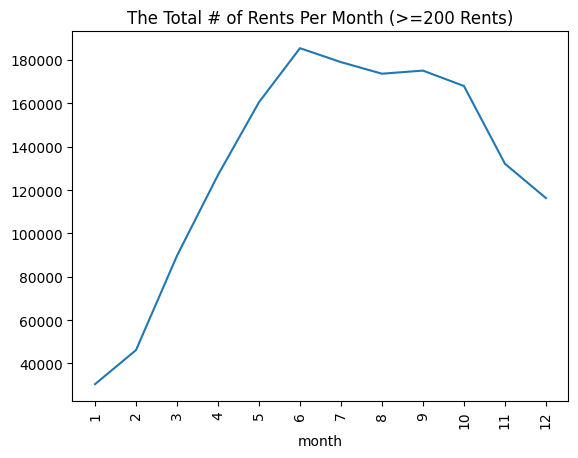

In [13]:
counts_per_month = huge_df.groupby('month')['count'].sum()
counts_per_month.plot(kind='line')
plt.title("The Total # of Rents Per Month (>=200 Rents)", fontsize=12)
plt.xticks(counts_per_month.index, rotation=90)
plt.show()

In [14]:
df.drop(columns=['datetime'], inplace=True)

<Axes: >

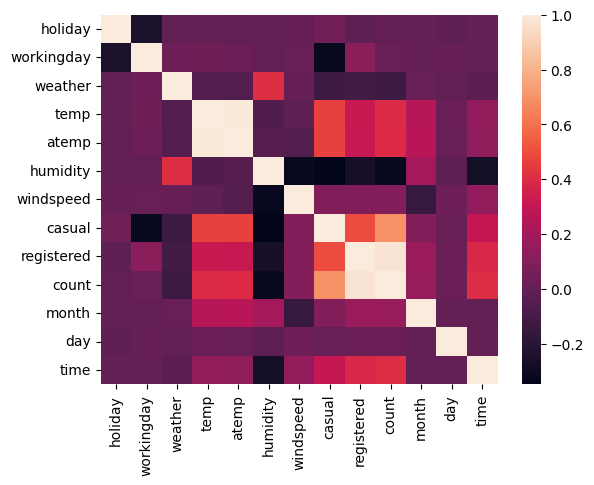

In [15]:
sns.heatmap(df.corr(numeric_only=True))

In [16]:
huge_df['season']

85       spring
122      spring
145      spring
239      spring
285      spring
          ...  
10878    winter
10879    winter
10880    winter
10881    winter
10882    winter
Name: season, Length: 4214, dtype: object

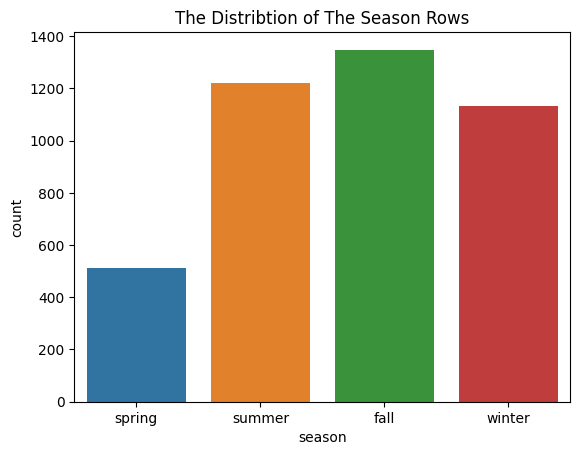

In [17]:
sns.countplot(data=huge_df, x='season')
plt.title("The Distribtion of The Season Rows")
plt.show()

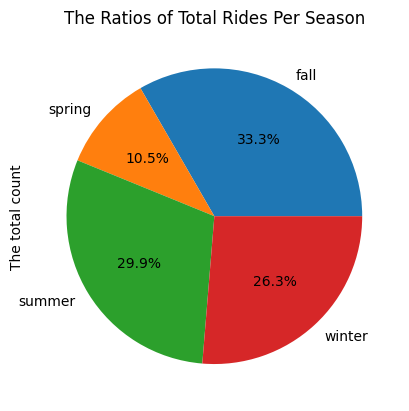

In [18]:
huge_df.groupby('season')['count'].sum().plot(kind='pie', autopct='%1.1f%%')
plt.title("The Ratios of Total Rides Per Season")
plt.ylabel("The total count")
plt.show()

In [19]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'month',
       'day', 'time'],
      dtype='object')

In [20]:
df.holiday.value_counts()

holiday
0    10575
1      311
Name: count, dtype: int64

In [21]:
df.workingday.value_counts()

workingday
1    7412
0    3474
Name: count, dtype: int64

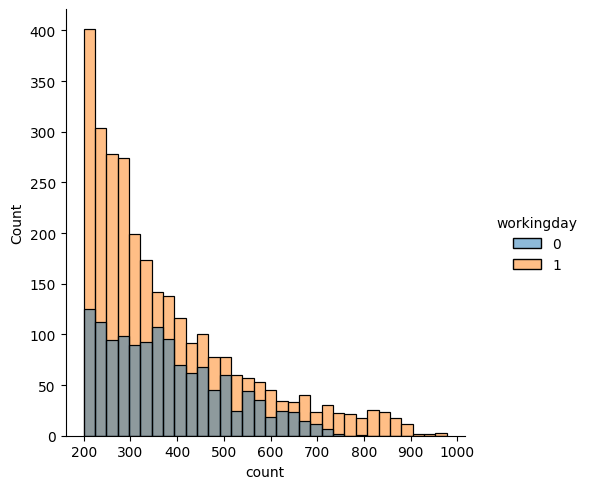

In [22]:
sns.displot(data=huge_df, x='count', hue='workingday')
plt.show()

In [23]:
df.registered.sum()

1693341

In [24]:
df.casual.sum()

392135

In [25]:
df.drop(columns=['registered', 'casual'], inplace=True)

In [26]:
season_values = df['season'].values.reshape(-1, 1)
encoder = OneHotEncoder()
season_values = encoder.fit_transform(season_values).toarray()  
df[list(encoder.categories_[0])] = season_values
df.drop(columns='season', inplace=True)

In [27]:
df.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,time,fall,spring,summer,winter
0,0,0,1,9.84,14.395,81,0.0,16,1,1,0,0.0,1.0,0.0,0.0
1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,0.0,1.0,0.0,0.0
2,0,0,1,9.02,13.635,80,0.0,32,1,1,2,0.0,1.0,0.0,0.0
3,0,0,1,9.84,14.395,75,0.0,13,1,1,3,0.0,1.0,0.0,0.0
4,0,0,1,9.84,14.395,75,0.0,1,1,1,4,0.0,1.0,0.0,0.0


In [28]:
encoder.categories_

[array(['fall', 'spring', 'summer', 'winter'], dtype=object)]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     10886 non-null  int64  
 1   workingday  10886 non-null  int64  
 2   weather     10886 non-null  int64  
 3   temp        10886 non-null  float64
 4   atemp       10886 non-null  float64
 5   humidity    10886 non-null  int64  
 6   windspeed   10886 non-null  float64
 7   count       10886 non-null  int64  
 8   month       10886 non-null  int32  
 9   day         10886 non-null  int32  
 10  time        10886 non-null  int32  
 11  fall        10886 non-null  float64
 12  spring      10886 non-null  float64
 13  summer      10886 non-null  float64
 14  winter      10886 non-null  float64
dtypes: float64(7), int32(3), int64(5)
memory usage: 1.1 MB


In [30]:
X = df.drop(columns='count')
y = df['count']

In [31]:
reg = DecisionTreeRegressor()
pararm_grid = {'criterion': ['squared_error', 'absolute_error'], 'max_depth': range(3,13)}

In [32]:
model = GridSearchCV(reg, pararm_grid, cv=5, n_jobs=-1)

In [33]:
model.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': range(3, 13)})

In [34]:
model.best_params_

{'criterion': 'squared_error', 'max_depth': 9}

In [35]:
model.score(X, y)

0.8403179905795212

In [36]:
reg_best_params = DecisionTreeRegressor(criterion='squared_error', max_depth=9)

In [37]:
reg_best_params.fit(X, y)

DecisionTreeRegressor(max_depth=9)

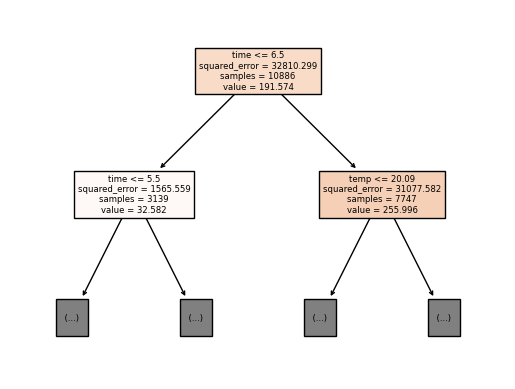

In [38]:
plot_tree(reg_best_params, feature_names=X.columns, filled=True, max_depth=1)
plt.show()

In [39]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['time'] = df['datetime'].dt.hour
    df.drop(columns=['datetime'], inplace=True)
    
    df['season'].replace({1 : "spring", 2 : "summer", 3 : "fall", 4 : "winter"}, inplace=True)

    season_values = df['season'].values.reshape(-1, 1)

    
    encoder = OneHotEncoder()
    season_values = encoder.fit_transform(season_values).toarray()
   
    df[list(encoder.categories_[0])] = season_values
    df.drop(columns='season', inplace=True)

    return df

In [40]:
test_df = wrangle("/kaggle/input/bike-sharing-demand/test.csv")
test_df.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,time,fall,spring,summer,winter
0,0,1,1,10.66,11.365,56,26.0027,1,20,0,0.0,1.0,0.0,0.0
1,0,1,1,10.66,13.635,56,0.0000,1,20,1,0.0,1.0,0.0,0.0
2,0,1,1,10.66,13.635,56,0.0000,1,20,2,0.0,1.0,0.0,0.0
3,0,1,1,10.66,12.880,56,11.0014,1,20,3,0.0,1.0,0.0,0.0
4,0,1,1,10.66,12.880,56,11.0014,1,20,4,0.0,1.0,0.0,0.0


In [41]:
xgb_reg = XGBRegressor(random_state=42)

In [42]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1]
}

In [43]:
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

In [44]:
grid_search.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [45]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 150}

In [46]:
best_xgb_model = grid_search.best_estimator_

In [47]:
xgb_predictions = best_xgb_model.predict(test_df)
xgb_predictions[:5]

array([54.67614 , 51.137173, 46.432617, 46.432617, 46.432617],
      dtype=float32)

<Figure size 1000x600 with 0 Axes>

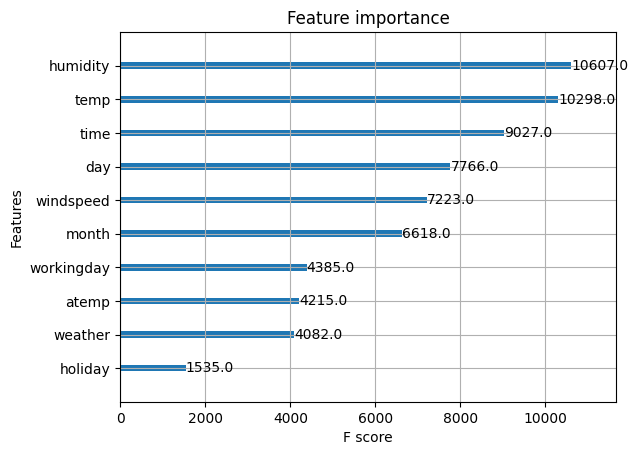

In [48]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_xgb_model, max_num_features=10) 
plt.show()

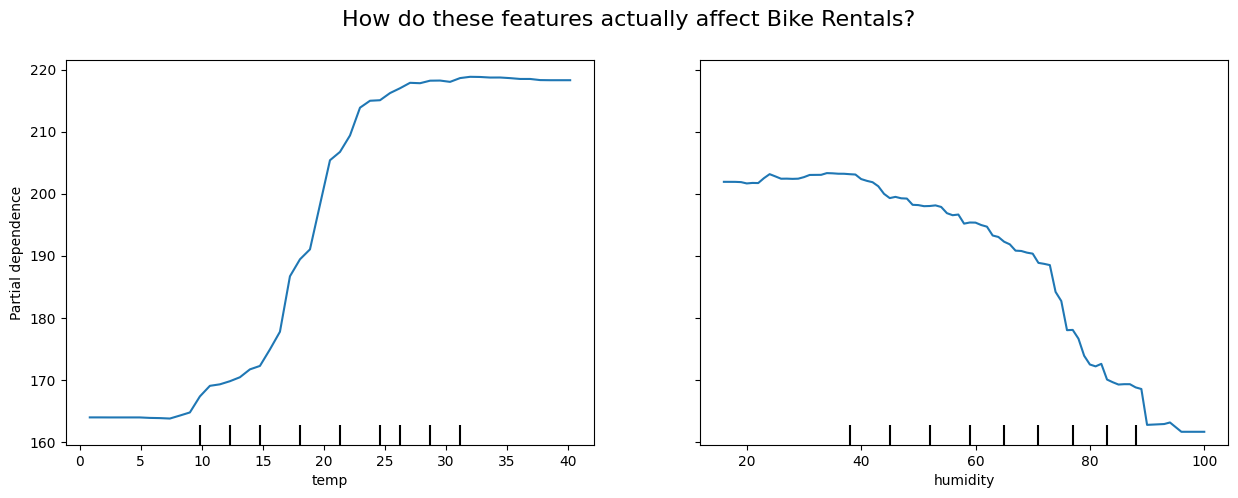

In [49]:
features_to_plot = ['temp', 'humidity']


fig, ax = plt.subplots(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(best_xgb_model, test_df, features_to_plot, ax=ax)

plt.suptitle("How do these features actually affect Bike Rentals?", fontsize=16)
plt.show()

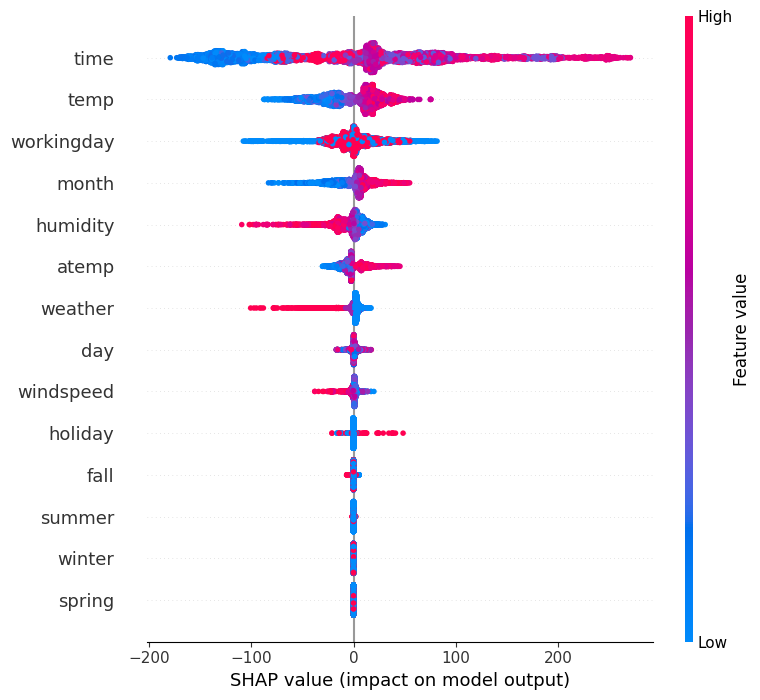

In [50]:
import shap

explainer = shap.TreeExplainer(best_xgb_model)

shap_values = explainer.shap_values(test_df)

shap.summary_plot(shap_values, test_df)

In [51]:
train_predictions = best_xgb_model.predict(X)

mae = mean_absolute_error(y, train_predictions)
mse = mean_squared_error(y, train_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y, train_predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared Score: {r2:.4f}")

Mean Absolute Error (MAE): 51.58
Root Mean Squared Error (RMSE): 70.66
R-Squared Score: 0.8478


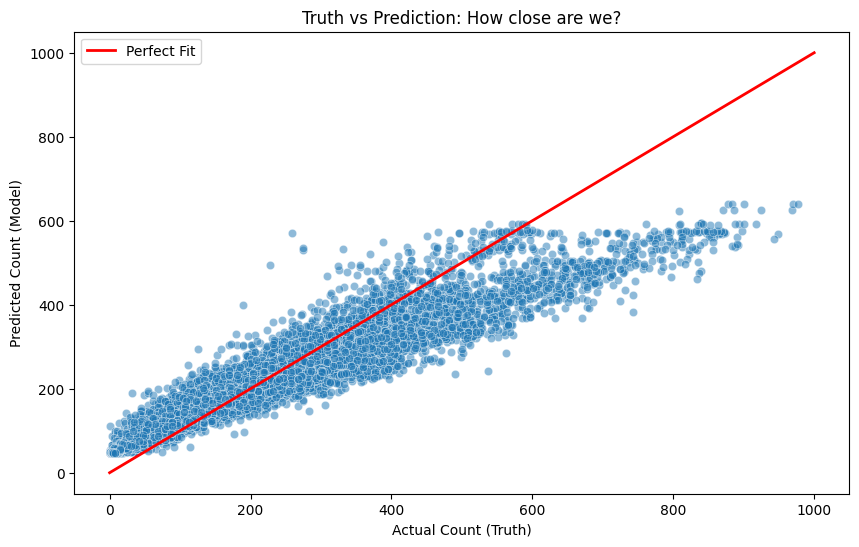

In [52]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y, y=train_predictions, alpha=0.5)

plt.plot([0, 1000], [0, 1000], color='red', linewidth=2, label='Perfect Fit')

plt.xlabel("Actual Count (Truth)")
plt.ylabel("Predicted Count (Model)")
plt.title("Truth vs Prediction: How close are we?")
plt.legend()
plt.show()

In [53]:
X_train_part, X_val, y_train_part, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

temp_xgb = XGBRegressor(n_estimators=150, 
                        learning_rate=0.01, 
                        max_depth=10, 
                        random_state=42)

temp_xgb.fit(X_train_part, y_train_part)

train_preds_xgb = temp_xgb.predict(X_train_part)
val_preds_xgb = temp_xgb.predict(X_val)


train_score_xgb = mean_absolute_error(y_train_part, train_preds_xgb)
val_score_xgb = mean_absolute_error(y_val, val_preds_xgb)

print("--- XGBOOST DIAGNOSTIC RESULTS ---")
print(f"Training Error (Memorization): {train_score_xgb:.2f}")
print(f"Validation Error (Real World): {val_score_xgb:.2f}")
print(f"Difference: {val_score_xgb - train_score_xgb:.2f}")

--- XGBOOST DIAGNOSTIC RESULTS ---
Training Error (Memorization): 50.71
Validation Error (Real World): 60.42
Difference: 9.71


In [54]:
rf_reg = RandomForestRegressor(random_state=42)

In [55]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [8, 10, 12]
}

In [56]:
grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=1)

In [57]:
grid_search_rf.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12], 'n_estimators': [100, 200]},
             verbose=1)

In [58]:
grid_search_rf.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [59]:
best_rf_model = grid_search_rf.best_estimator_

In [60]:
rf_predictions = best_rf_model.predict(test_df)

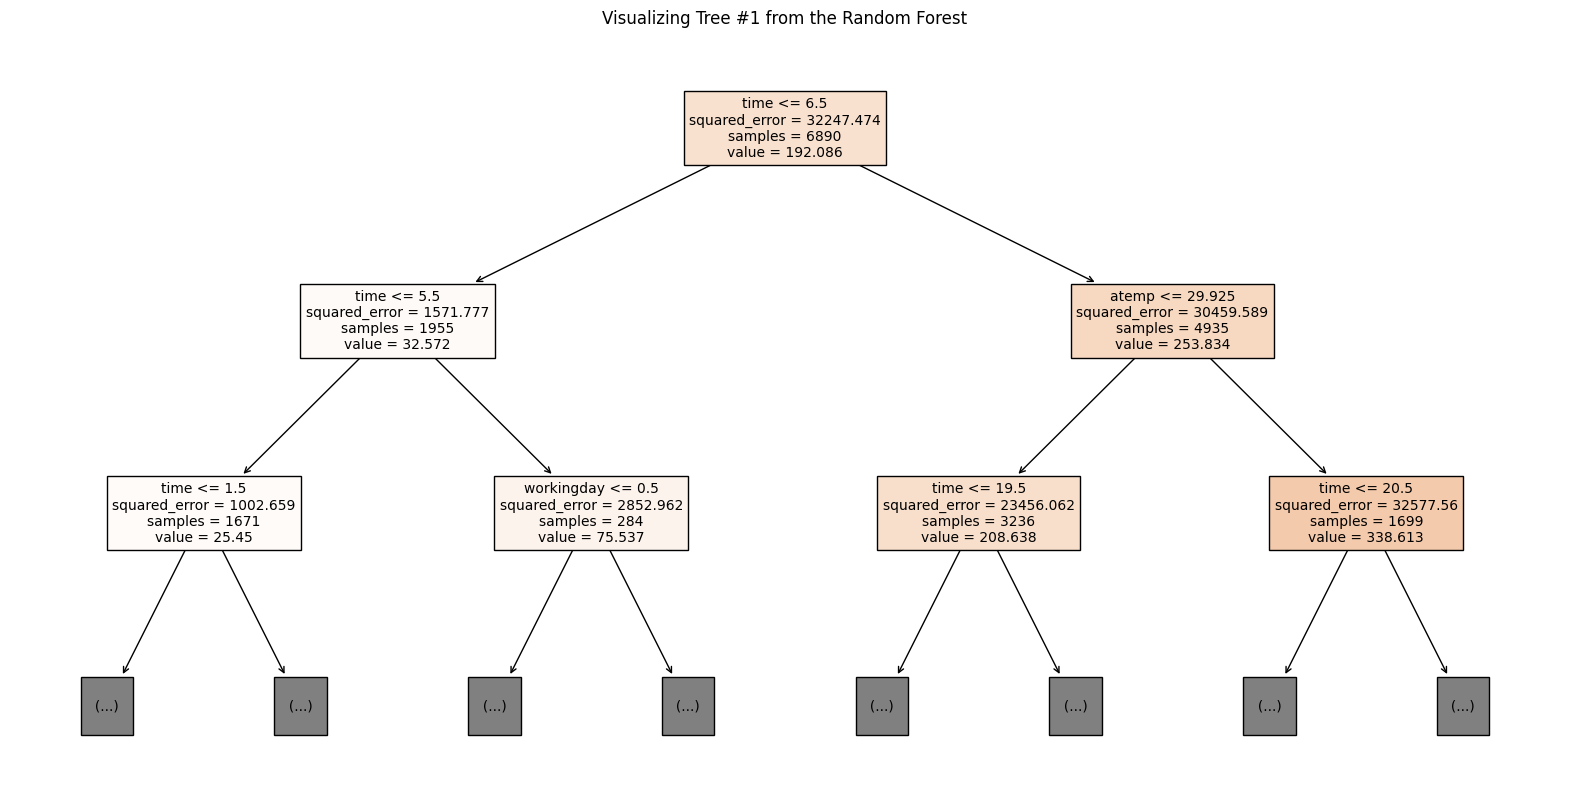

In [61]:
plt.figure(figsize=(20, 10))


plot_tree(best_rf_model.estimators_[0], 
          feature_names=test_df.columns,  
          filled=True, 
          max_depth=2, 
          fontsize=10)

plt.title("Visualizing Tree #1 from the Random Forest")
plt.show()

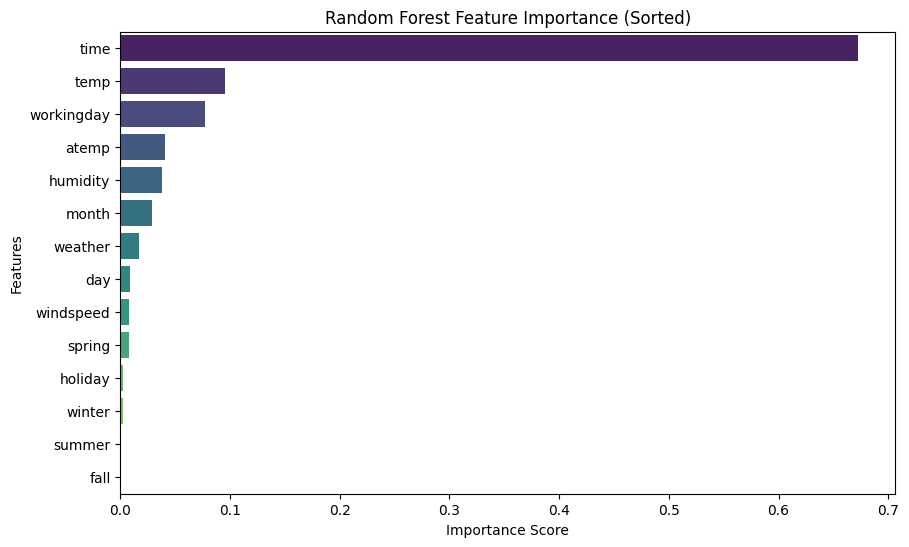

In [62]:
importances = best_rf_model.feature_importances_
feature_names = test_df.columns  

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')

plt.title("Random Forest Feature Importance (Sorted)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [63]:
rf_train_predictions = best_rf_model.predict(X)

mae_rf = mean_absolute_error(y, rf_train_predictions)
mse_rf = mean_squared_error(y, rf_train_predictions)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y, rf_train_predictions)

print("--- RANDOM FOREST RESULTS ---")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R-Squared Score: {r2_rf:.4f}")

--- RANDOM FOREST RESULTS ---
Mean Absolute Error (MAE): 41.13
Root Mean Squared Error (RMSE): 61.30
R-Squared Score: 0.8855


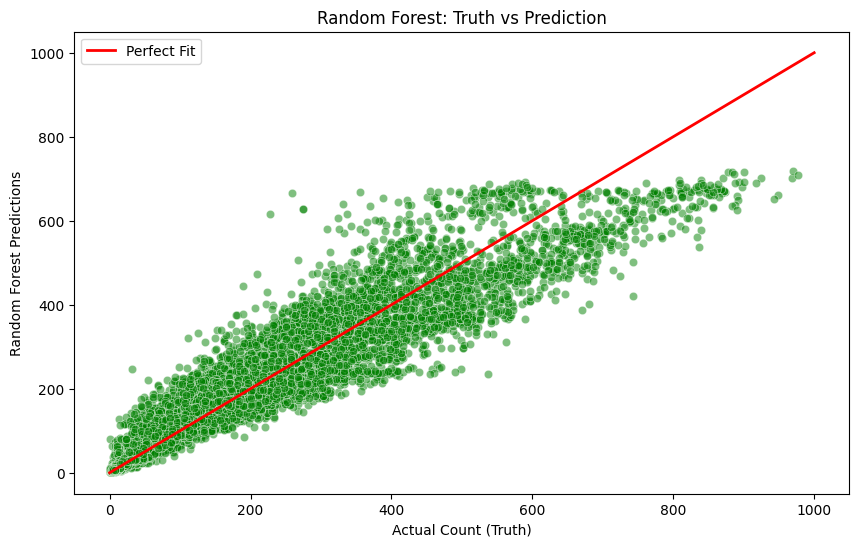

In [64]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y, y=rf_train_predictions, alpha=0.5, color='green')

plt.plot([0, 1000], [0, 1000], color='red', linewidth=2, label='Perfect Fit')

plt.xlabel("Actual Count (Truth)")
plt.ylabel("Random Forest Predictions")
plt.title("Random Forest: Truth vs Prediction")
plt.legend()
plt.show()

In [65]:
X_train_part, X_val, y_train_part, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


temp_rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
temp_rf.fit(X_train_part, y_train_part)

train_score = mean_absolute_error(y_train_part, temp_rf.predict(X_train_part))
val_score = mean_absolute_error(y_val, temp_rf.predict(X_val))

print("--- DIAGNOSTIC RESULTS ---")
print(f"Training Error (Memorization): {train_score:.2f}")
print(f"Validation Error (Real World): {val_score:.2f}")
print(f"Difference: {val_score - train_score:.2f}")

--- DIAGNOSTIC RESULTS ---
Training Error (Memorization): 39.97
Validation Error (Real World): 49.47
Difference: 9.50


In [66]:
final_rf = RandomForestRegressor(n_estimators=200, 
                                 max_depth=10, 
                                 random_state=42,
                                 n_jobs=-1)

print("Training final model...")
final_rf.fit(X, y)

final_predictions = final_rf.predict(test_df)

submission = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')
submission['count'] = final_predictions


submission = submission[['datetime', 'count']]
submission.to_csv('submission.csv', index=False)

print("SUCCESS! File 'submission.csv' is saved and ready.")

Training final model...
SUCCESS! File 'submission.csv' is saved and ready.


In [67]:
sub = pd.read_csv('submission.csv')
sub


,datetime,count
0,2011-01-20 00:00:00,13.920573
1,2011-01-20 01:00:00,6.189129
2,2011-01-20 02:00:00,5.774488
3,2011-01-20 03:00:00,2.992252
4,2011-01-20 04:00:00,2.716589
...,...,...
6488,2012-12-31 19:00:00,266.505958
6489,2012-12-31 20:00:00,175.539669
6490,2012-12-31 21:00:00,128.908711
6491,2012-12-31 22:00:00,97.581248
